In [1]:
import os
import sys
import psycopg2
import numpy as np
from astropy.table import Table, vstack, Column
import astropy.io.ascii
import re
from glob import glob
from datetime import date, timedelta
from scipy import optimize
from scipy.optimize import minimize
import contextlib

from desimeter.util import parse_fibers
from desimeter.dbutil import dbquery,get_petal_ids,get_pos_ids,get_petal_loc

from desimeter.transform.pos2ptl import int2ptl, ptl2flat
from desimeter.posparams.posmoveselection import posmove_selection
from desimeter.circles import fit_circle, _fast_fit_circle
from desimeter.transform.ptl2fp import fp2ptl


import matplotlib.pyplot as plt
%pylab inline

# The petal DB tables are by index number, but we refer to fibers by location
petal_id2loc = {4:0, 5:1, 6:2, 3:3, 8:4, 10:5, 11:6, 2:7, 7:8, 9:9}

Populating the interactive namespace from numpy and matplotlib


/global/common/software/desi/cori/desiconda/20200801-1.4.0-spec/conda/lib/python3.8/site-packages/IPython/core/magics/pylab.py:159: UserWarning: pylab import has clobbered these variables: ['vstack']
`%matplotlib` prevents importing * from pylab and numpy
  warn("pylab import has clobbered these variables: %s"  % clobbered +


In [2]:
# Helper functions for parsing the tables
re_phi_arc = re.compile('phi arc')
re_theta_arc = re.compile('theta arc')

def parse_int(string):
    if string == None: return 0
    else: return int(string)
def parse_float(string):
    if string == None: return 0
    else: return float(string)

In [3]:
# Connect to the database
args = {'host': 'db.replicator.dev-cattle.stable.spin.nersc.org', 'port': 60042, 'password': None}
print(args)

comm = psycopg2.connect(host=args['host'],port=args['port'], database='desi_dev', user='desi_reader',password=args['password'])

{'host': 'db.replicator.dev-cattle.stable.spin.nersc.org', 'port': 60042, 'password': None}


In [4]:
# Fetch a petal of data for the given exposure
def fetchDB(night, expos, lastexpos=False, petal=-1):
    if not lastexpos: lastexpos = expos
    _night = f'{night:08d}'
    _night = date(int(_night[0:4]),int(_night[4:6]),int(_night[6:8]))
    today = _night+timedelta(days=1)
    tomorrow = _night+timedelta(days=2)
    print("Searching DB from", today.isoformat(), 'to', tomorrow.isoformat())
    if petal>=0: 
        print("Fetching petal_id", petal)
        petal_id = f'_p{petal:d}'
    else: 
        print("Fetching all petals")
        petal_id = ''

    # obs_x,y, petal_id, pos_id, log_note
    cmd = f"select time_recorded, pos_id, petal_id, obs_x, obs_y, log_note \
    from posmovedb.positioner_moves{petal_id:s} \
    where (time_recorded>'{today.isoformat():s}') \
    and (time_recorded<'{tomorrow.isoformat():s}') \
    and (exposure_id >= {expos:5d}) \
    and (exposure_id <= {lastexpos:5d}) \
    and (ctrl_enabled = True) \
    order by pos_id,time_recorded desc"
    #print(cmd)
    moves=dbquery(comm,cmd)
    moves = Table(moves)
    print(len(moves), "moves retrieved.  Processing....")
    obs_x = np.array(list(map(parse_float,moves['obs_x'])))
    obs_y = np.array(list(map(parse_float,moves['obs_y'])))
    moves.remove_column('obs_x')
    moves.remove_column('obs_y')
    #moves.rename_column('obs_x', 'obs_x_orig')
    #moves.rename_column('obs_y', 'obs_y_orig')
    moves.add_column(obs_x, name='obs_x')
    moves.add_column(obs_y, name='obs_y')
    
    # TODO: This needs to be adjusted if we want to handle the full DB
    print(f"Converting to petal coordinates")
    z_fp = None
    petal_loc = [petal_id2loc[x] for x in moves['petal_id']]

    x_ptl_meas = np.zeros(len(moves))
    y_ptl_meas = np.zeros(len(moves))
    for n in range(len(moves)):
        x_ptl_meas[n],y_ptl_meas[n],_ = fp2ptl(petal_loc[n],obs_x[n],obs_y[n],z_fp)
    x_flat, y_flat = ptl2flat(x_ptl_meas, y_ptl_meas)
        
    #moves.add_column(x_ptl_meas, index=8, name='x_ptl_meas')
    #moves.add_column(y_ptl_meas, index=9, name='y_ptl_meas')
    moves.add_column(x_flat, name='x_flat')
    moves.add_column(y_flat, name='y_flat')
    
    epoch = moves["time_recorded"][0].isoformat()
    print("Retrieving calibrations from epoch: ",epoch)
    
    cmd = f"select t.* from posmovedb.positioner_calibration{petal_id:s} t \
    inner join ( \
        select pos_id, max(time_recorded) as MaxDate \
        from posmovedb.positioner_calibration{petal_id:s} \
        where (time_recorded < '{epoch:s}') \
        group by pos_id \
    ) tm on t.pos_id = tm.pos_id and t.time_recorded = tm.MaxDate \
    order by t.pos_id" 
    #print(cmd)
    cals = dbquery(comm,cmd)
    cals = Table(cals)
    print(len(cals), "cals retrieved")

    cmd = f"select t.* from posmovedb.positioner_calibration{petal_id:s} t \
    inner join ( \
        select pos_id, max(time_recorded) as MaxDate \
        from posmovedb.positioner_calibration{petal_id:s} \
        group by pos_id \
    ) tm on t.pos_id = tm.pos_id and t.time_recorded = tm.MaxDate \
    order by t.pos_id" 
    #print(cmd)
    present_cals = dbquery(comm,cmd)
    present_cals = Table(present_cals)  
    print(len(present_cals), "present cals retrieved")
    
    if np.sum(np.where(cals['pos_id']==present_cals['pos_id'],0,1))>0:
        print("Critical error: cals and present_cals order doesn't match")
    else: 
        print("Order of cals and present_cals confirmed to match.")
    
    for n in ['offset_x', 'offset_y', 'length_r1', 'length_r2']:
        cals[n].info.format = '6.4f'
        present_cals[n].info.format = '6.4f'
    for n in ['offset_t', 'offset_p', 'physical_range_t', 'physical_range_p']:
        cals[n].info.format = '6.4f'
        present_cals[n].info.format = '6.4f'
    
    moves.remove_column('petal_id')
    moves.remove_column('time_recorded')
    return moves, cals, present_cals

#moves, cals, present_cals = fetchDB(20210622,95546) #,petal=2)
moves, cals, present_cals = fetchDB(20210623,95734,lastexpos=95737) #,petal=2)

Searching DB from 2021-06-24 to 2021-06-25
Fetching all petals
222870 moves retrieved.  Processing....
Converting to petal coordinates
Retrieving calibrations from epoch:  2021-06-24T09:34:37.621309+00:00
5020 cals retrieved
5020 present cals retrieved
Order of cals and present_cals confirmed to match.


In [5]:
pos2idx = {pos_id:idx for idx,pos_id in enumerate(cals["pos_id"])}

In [6]:
new_cals = Table()
new_cals.add_column(present_cals['pos_id'], name='pos_id')
new_cals.add_column(np.zeros(len(new_cals),dtype=np.float32), name='length_r1')
new_cals.add_column(np.zeros(len(new_cals),dtype=np.float32), name='length_r2')
new_cals.add_column(np.zeros(len(new_cals),dtype=np.float32), name='offset_x')
new_cals.add_column(np.zeros(len(new_cals),dtype=np.float32), name='offset_y')
new_cals.add_column(np.zeros(len(new_cals),dtype=np.float32), name='arc_t')
new_cals.add_column(np.zeros(len(new_cals),dtype=np.float32), name='arc_p')
new_cals.add_column(np.zeros(len(new_cals),dtype=np.float32), name='rms_t')
new_cals.add_column(np.zeros(len(new_cals),dtype=np.float32), name='rms_p')
new_cals.add_column(np.zeros(len(new_cals),dtype=np.float32), name='err.length_r2')
new_cals.add_column(np.zeros(len(new_cals),dtype=np.float32), name='err.offset_xy')
new_cals.add_column(np.zeros(len(new_cals),dtype=np.float32), name='nfit_t')
new_cals.add_column(np.zeros(len(new_cals),dtype=np.float32), name='nfit_p')
new_cals.add_column(np.zeros(len(new_cals),dtype=np.float32), name='nprune_t')
new_cals.add_column(np.zeros(len(new_cals),dtype=np.float32), name='nprune_p')
new_cals.add_column(np.zeros(len(new_cals),dtype=np.float32), name='theta_arc_radius')
new_cals.add_column(np.zeros(len(new_cals),dtype=np.float32), name='theta_arc_phi')
new_cals.add_column(np.zeros(len(new_cals),dtype=np.float32), name='median_angstep_t')
new_cals.add_column(np.zeros(len(new_cals),dtype=np.float32), name='median_angstep_p')
new_cals.add_column(np.zeros(len(new_cals),dtype=np.float32), name='rms_angstep_t')
new_cals.add_column(np.zeros(len(new_cals),dtype=np.float32), name='rms_angstep_p')
new_cals.add_column(np.zeros(len(new_cals),dtype=np.float32), name='max_p')

for n in list(new_cals.keys())[1:]:
    new_cals[n].info.format = '6.4f'

new_cals['nfit_t'].info.format = '2.0f'
new_cals['nfit_p'].info.format = '2.0f'
new_cals['nprune_t'].info.format = '2.0f'
new_cals['nprune_p'].info.format = '2.0f'

In [7]:
moves.dtype

dtype([('pos_id', '<U6'), ('log_note', '<U265'), ('obs_x', '<f8'), ('obs_y', '<f8'), ('x_flat', '<f8'), ('y_flat', '<f8')])

In [8]:
cals.dtype

dtype([('petal_id', '<i8'), ('device_loc', '<i8'), ('pos_id', '<U6'), ('pos_calib_index', '<i8'), ('time_recorded', 'O'), ('bus_id', '<U5'), ('length_r1', '<f8'), ('length_r2', '<f8'), ('offset_x', '<f8'), ('offset_y', '<f8'), ('offset_t', '<f8'), ('offset_p', '<f8'), ('physical_range_t', '<f8'), ('physical_range_p', '<f8'), ('gear_calib_t', '<f8'), ('gear_calib_p', '<f8'), ('total_limit_seeks_t', '<f8'), ('total_limit_seeks_p', '<f8'), ('last_primary_hardstop_dir_t', '<f8'), ('last_primary_hardstop_dir_p', '<f8'), ('keepout_expansion_phi_radial', '<f8'), ('keepout_expansion_phi_angular', '<f8'), ('keepout_expansion_theta_radial', '<f8'), ('keepout_expansion_theta_angular', '<f8'), ('classified_as_retracted', '?'), ('site', '<U4'), ('calib_note', '<U1'), ('fiber_intact', '?'), ('device_classified_nonfunctional', '?')])

In [9]:
moves[:1]

pos_id,log_note,obs_x,obs_y,x_flat,y_flat
str6,str265,float64,float64,float64,float64
M00282,"sequence: RC_CALIB; phi arc +10; sequence_move_idx 20; move 21; CURR_SPIN_UP_DOWN=70; CURR_CRUISE=70; CURR_CREEP=70; req_posintTP=(-94.858, 122.755); req_ptlXYZ=(227.553, 26.005, -5.713)",199.374205646163,-112.69578781033,227.65149835870704,26.02267432514453


In [10]:
def dje_fit_circle_old(x,y,diag=False):
    # Alas, the base implementation has the annoying property that 
    # it raises an error if the radius is outside [1,5], despite that
    # retracted positioners will yield small radius circles.
    # We're going to hack this here.
    try: 
         xc,yc,r = fit_circle(x, y)
    except: 
        try: 
            if diag: print("Refitting x4")
            xc,yc,r = fit_circle(4*x,4*y)
            xc = xc/4
            yc = yc/4
            r = r/4
        except:
            try: 
                if diag: print("Refitting /4")
                xc,yc,r = fit_circle(0.25*x,0.25*y)
                xc = xc*4
                yc = yc*4
                r = r*4
            except:
                try: 
                    if diag: print("Refitting x16")
                    xc,yc,r = fit_circle(16*x,16*y)
                    xc = xc/16
                    yc = yc/16
                    r = r/16
                except:
                    if diag: print("Giving up on fitting in dje_fit_circle_old")
                    return None
    return xc,yc,r

def dje_fit_circle(x,y,tol,diag=False):
    # Alas, the base implementation has the annoying property that 
    # it raises an error if the radius is outside [1,5], despite that
    # retracted positioners will yield small radius circles.
    # We're going to hack this here.
    
    # Use a median-based fit and then reject 10x(tol) outliers from it.
    x_m, y_m, r_m = _fast_fit_circle(x, y, use_median=True)
    if diag: print("Median:", x_m, y_m, r_m)
    chi = np.abs(np.sqrt((x-x_m)**2+(y-y_m)**2)-r_m)/tol
    sel = (chi<10)
    if (np.sum(sel)<5): 
        if diag: print(f"Rejected {np.sum(~sel)} points after median")
        return None
    # Now do the proper mean-based fit with the retained objects.
    if diag: print(np.sum(sel), "used in dje_fit_circle()")
    ret = dje_fit_circle_old(x[sel], y[sel], diag=diag)
    if ret: xc, yc, r = ret
    else: 
        if diag: print("Accepting the median-based fit")
        x_m, y_m, r_m = _fast_fit_circle(x[sel], y[sel], use_median=True)
        return x_m, y_m, r_m
        #return None
    if diag: print("Mean:  ", xc, yc, r)
    return xc, yc, r

In [11]:
def wrapped_angle_range_old(ang):
    ang = ang-np.median(ang)
    ang = np.where(ang>np.pi, ang-2*np.pi, ang)
    ang = np.where(ang<-np.pi, ang+2*np.pi, ang)
    return np.max(ang)-np.min(ang)

def wrapped_angle_range(ang):
    for n in range(1,len(ang)):
        if ang[n]-ang[n-1]<-180: ang[n] = ang[n]+360.0
        if ang[n]-ang[n-1]>180: ang[n] = ang[n]-360.0
    return np.max(ang)-np.min(ang)

def prune_moves_old(x,y,tol):
    # We occasionally have points that are very close to each other
    sel = (x<1e10)   # Start with everything True
    enum = np.arange(len(x))
    tol2 = tol*tol
    for n in range(len(x)):
        sel = np.where( ((x-x[n])**2+(y-y[n])**2<tol2)&(enum>n), False, sel)
    x = x[sel]
    y = y[sel]
    return x,y,np.sum(~sel)

def prune_moves(x,y,tol):
    # We occasionally have points that are very close to their neighbor
    sel = (x<1e10)   # Start with everything True
    tol2 = tol*tol
    sel[1:] = ((x[1:]-x[:-1])**2+(y[1:]-y[:-1])**2>tol2)  # Differs from neighbor
    x = x[sel]
    y = y[sel]
    return x,y,np.sum(~sel)

def fit_arc(move,pos_id,tol,cen=[],diag=False,ignore=0):
    # Returning range=-9: insufficient data at the start
    # Returning range=-5: <=3 non-duplicate data points
    # Returning range=-8, -3 after rejection: data shows a small rms extent, probably no motor motion
    # Returning range=-2: insufficient data after rejection
    # Returning range=-1: fit_circle otherwise failed
    # tol is the pruning tolerance, in microns
    # If cen is given, then it is a vector to refer phi=180 to
    def error(val): return np.array([0.0,0.0,0.0,0.0,val,0.0,len(x),Nprune,0.0,0.0,0.0]), None
    x = move['x_flat']
    y = move['y_flat']
    nreq = (len(x)+2)//2
    Nprune = 0
    tol = tol/5000.0   # We use millimeters in the code, and we refer to 5-sigma.
    if diag: print(len(x), "moves to start")
    if (len(x)<nreq): return error(-9.0)
    extent = np.sqrt(np.var(x)+np.var(y))
    if extent<0.1: return error(-8.0)
    
    x,y,Nprune = prune_moves(x,y,0.02)   # Only keep points that differ by 20 microns
    if diag: print(len(x), "moves after prune_moves()")
    if (len(x)<4): return error(-5.0) 

    #try: xc,yc,r = 
    ret = dje_fit_circle(x, y, tol, diag=diag)
    if ret: xc,yc,r = ret
    else: return error(-1.0)
    
    # Do one attempt at rejecting points more than 30 microns from the result.
    chi = np.abs(np.sqrt((x-xc)**2+(y-yc)**2)-r)/tol
    if (np.max(chi)>5): 
        sel = (chi<5)
        print(f"{pos_id:s}: rejecting {np.sum(~sel)} points, largest chi={np.max(chi)}")
        x = x[sel]
        y = y[sel]
        if (len(x)<nreq): return error(-2.0) 
        extent = np.sqrt(np.var(x)+np.var(y))
        if extent<0.05: return error(-3.0)
        ret = dje_fit_circle(x, y, tol, diag=diag)
        if ret: xc,yc,r = ret
        else: return error(-1.0)
        #try: xc,yc,r = dje_fit_circle(x, y, diag=diag)
        #except: return error(-1.0)
    
    npoints = len(x)

    def compute_chi2(params):
        # params are xc,yc,r
        # Assuming 10 micron spot errors per dimension
        return np.sum(( np.sqrt((x-params[0])**2+(y-params[1])**2)-params[2])**2)/0.0001

    # This is doing an extra optimization
    initial = np.array([xc,yc,r])
    optimizer_result = minimize(fun=compute_chi2, x0=initial, method='Powell', options={'maxiter':160})
    if optimizer_result.success:
        xc = optimizer_result.x[0]
        yc = optimizer_result.x[1]
        r  = optimizer_result.x[2]
        p = optimizer_result.x
    else:
        print("Optimizer did not converge.", pos_id, xc,yc,r, optimizer_result)
        p = np.array([xc,yc,r])
    
    # Now attempt to find the Hessian of the chi2 surface
    # chi2 = chi_0 + (1/2)d^2(chi)/dx_i dx_j * delta_i delta_j
    #      = chi_0 + (1/2) hess_ij delta_i delta_j
    # We compute this with both parities, so
    # (chi2_pos+chi2_neg-2*chi_0) = hess_ij delta_i delta_j
    def second_deriv(chi2,p,offset): return compute_chi2(p+offset)+compute_chi2(p-offset)-2*chi2
    chi2 = compute_chi2(p)
    hess = np.zeros([3,3])
    hess[0,0] = second_deriv(chi2,p,[0.01,0.0 ,0.0 ])
    hess[1,1] = second_deriv(chi2,p,[0.0 ,0.01,0.0 ])
    hess[2,2] = second_deriv(chi2,p,[0.0 ,0.0 ,0.01])
    hess[0,1] = (second_deriv(chi2,p,[0.01,0.01,0.0 ])-(hess[0,0]+hess[1,1]))/2.0
    hess[0,2] = (second_deriv(chi2,p,[0.01,0.0 ,0.01])-(hess[0,0]+hess[2,2]))/2.0
    hess[1,2] = (second_deriv(chi2,p,[0.0 ,0.01,0.01])-(hess[2,2]+hess[1,1]))/2.0
    hess[1,0] = hess[0,1]
    hess[2,0] = hess[0,2]
    hess[2,1] = hess[1,2]
    hess = hess/0.01/0.01    # Correct for the step sizes
    hess = hess*((len(x)-3)/chi2)   # Renormalize to reduced chi2 of 1
    #print(hess)
    cov = numpy.linalg.inv(hess)
    #print(np.linalg.eigh(cov))
    try: 
        dg = np.diag(cov)
        if (np.min(dg)<0): print(pos_id, "Negative variance", dg)
        idg = np.where(dg>0.0, 1.0/np.sqrt(np.abs(dg)), 1.0)
        rcov = (cov*dg).T*dg
        #print(diag)
        #print(rcov)    
    except: pass
    
    ang = np.arctan2(y-yc,x-xc)*180.0/np.pi
    ang_range = wrapped_angle_range(ang)
    delta_ang = np.abs(np.remainder( (ang[1:]-ang[:-1])+540.0, 360.0)-180.0)
    
    # TODO: We opt to ignore the first 3 moves, because the theta arc does differently there.
    median_ang_step = np.median(delta_ang[ignore:])
    rms_ang_step = np.std(delta_ang[ignore:])
    if len(cen)>0:
        ang_c = np.arctan2(cen[1]-yc, cen[0]-xc)*180.0/np.pi
        # We want to define that to be 180 deg
        if diag: print("Central direction: ", ang_c)
        ang = np.remainder(ang-ang_c+180.0+720.0, 360.0)
        max_ang = np.max(ang)
    else:
        max_ang = -999.0
    if diag: print("Angles:", np.abs(median_ang_step), rms_ang_step, ang)

    r_res = np.array(np.sqrt((x-xc)**2+(y-yc)**2)-r)
    rms = np.sqrt(np.sum(r_res**2)/len(r_res))
    #rms = np.sqrt(np.sum((np.sqrt((x-xc)**2+(y-yc)**2)-r)**2)/len(x))
    if diag: print("Radial deviations (microns):", 1000.0*r_res,"\n")
    return np.array([xc,yc,r,rms,ang_range, extent, npoints, Nprune, median_ang_step, rms_ang_step, max_ang]), cov

In [12]:
def fit_arcs(pos_id, moves, cals, new_cals, idx, diag=False, tol=30):
    # tol is the pruning tolerance in microns
    move = moves[(moves['pos_id']==pos_id)]
    if not diag:
        new_cals['arc_t'][idx] = -9.0
        new_cals['arc_p'][idx] = -9.0
    if (len(move)<1):
        print(f"{pos_id} has no moves in the DB")
        return
    phi_arc = np.where(list([re_phi_arc.search(x) for x in move['log_note'] ]),True,False)
    theta_arc = np.where(list([re_theta_arc.search(x) for x in move['log_note'] ]),True,False)
    
    theta_arc, theta_cov = fit_arc(move[theta_arc], pos_id, tol, diag=diag,ignore=3)
    phi_arc, phi_cov = fit_arc(move[phi_arc], pos_id, tol, cen=theta_arc, diag=diag)

    if phi_arc[2]>0.0 and theta_arc[2]>0.0:
        theta_r = np.sqrt((phi_arc[0]-theta_arc[0])**2+(phi_arc[1]-theta_arc[1])**2)
        # Estimate the phi where the theta arc was performed
        # 1+cos(phi) = (r_arc**2 - [r1-r2])
        theta_arc_phi = (theta_arc[2]**2-(phi_arc[2]-theta_r)**2)/(2.0*phi_arc[2]*theta_r)
        if (theta_arc_phi>=0.0): theta_arc_phi = np.arccos(theta_arc_phi-1.0)*180/np.pi
        else: theta_arc_phi = 180.0 
        # Note that this value assumes phi<180, but values at phi>180 aren't excluded!
    else:
        theta_r = 0.0
        theta_arc_phi = 0.0
    
    if diag: 
        print("Theta arc:", theta_arc)
        print("Phi arc:  ", phi_arc)
        print("Theta rad:", theta_r)
        print("Theta_arc_phi:", theta_arc_phi)
        return   # Don't overwrite the new_cals Table
    new_cals['offset_x'][idx] = theta_arc[0]
    new_cals['offset_y'][idx] = theta_arc[1]
    new_cals['length_r1'][idx] = theta_r
    new_cals['length_r2'][idx] = phi_arc[2]
    new_cals['err.length_r2'][idx] = 9.99
    if phi_cov is not None: 
        if phi_cov[2,2]>=0.0: new_cals['err.length_r2'][idx] = np.sqrt(phi_cov[2,2])
    if theta_cov is not None: 
        if theta_cov[2,2]>=0.0: new_cals['err.offset_xy'][idx] = np.sqrt(theta_cov[0,0]+theta_cov[1,1])    
    new_cals['arc_t'][idx] = theta_arc[4]
    new_cals['arc_p'][idx] = phi_arc[4]
    new_cals['rms_t'][idx] = theta_arc[3]
    new_cals['rms_p'][idx] = phi_arc[3]
    new_cals['nfit_t'][idx] = theta_arc[6]
    new_cals['nfit_p'][idx] = phi_arc[6]
    new_cals['nprune_t'][idx] = theta_arc[7]
    new_cals['nprune_p'][idx] = phi_arc[7]
    new_cals['theta_arc_radius'][idx] = theta_arc[2]
    new_cals['theta_arc_phi'][idx] = theta_arc_phi
    new_cals['median_angstep_t'][idx] = theta_arc[8]
    new_cals['median_angstep_p'][idx] = phi_arc[8]
    new_cals['rms_angstep_t'][idx] = theta_arc[9]
    new_cals['rms_angstep_p'][idx] = phi_arc[9]
    new_cals['max_p'][idx] = phi_arc[10]

    return

In [67]:
for idx, pos_id in enumerate(cals['pos_id']):
    fit_arcs(pos_id, moves, cals, new_cals, idx)

M01133 has no moves in the DB
M01190 has no moves in the DB
M01276 has no moves in the DB
M01482 has no moves in the DB
M01485 has no moves in the DB
M01489 has no moves in the DB
M01490 has no moves in the DB
M01679 has no moves in the DB
M01684 has no moves in the DB
M01690 has no moves in the DB
M01719 has no moves in the DB
M01727 has no moves in the DB
M01764 has no moves in the DB
M01784: rejecting 1 points, largest chi=6.163112195382976
M01784: rejecting 1 points, largest chi=5.840929132735928
M01956 has no moves in the DB
M02060 has no moves in the DB
M02065 has no moves in the DB
M02113: rejecting 5 points, largest chi=6.676584414126922
M02351 has no moves in the DB
M02433 has no moves in the DB
M02480 has no moves in the DB
M02547 has no moves in the DB
M02551: rejecting 1 points, largest chi=5.810600383469404
M02582 has no moves in the DB
M02668 has no moves in the DB
M02732 has no moves in the DB
M02792 has no moves in the DB
M02809 has no moves in the DB
M02865: rejecting 

In [68]:
try: astropy.io.ascii.write(present_cals,'present_cals95734.ecsv',format='ecsv')
except: pass
try: astropy.io.ascii.write(cals,'cals95734.ecsv',format='ecsv')
except: pass
try: moves.write('moves95734.fits.gz')
except: pass

In [69]:
try: astropy.io.ascii.write(new_cals,'new_cals95734.ecsv',format='ecsv')
except: pass

In [13]:
def plot_fiber(fib, axsub=False, savefig=False):
    if not axsub: 
        fig,ax = plt.subplots(1,gridspec_kw=dict(hspace=0.2),figsize=(4,4))
        with np.printoptions(precision=3,suppress=True):
            new_cals[(new_cals['pos_id']==fib)].pprint_all()    
    else:
        ax = axsub
    f = moves[(moves['pos_id']==fib)]
    phi_arc = np.where(list([re_phi_arc.search(x) for x in f['log_note'] ]),True,False)
    theta_arc = np.where(list([re_theta_arc.search(x) for x in f['log_note'] ]),True,False)
    #fit_circle(f['X_FP'][theta_arc], f['Y_FP'][theta_arc])
    ax.scatter(f['obs_x'], f['obs_y'],s=8)
    ax.scatter(f['obs_x'][theta_arc], f['obs_y'][theta_arc], s=20, color='m')
    ax.scatter(f['obs_x'][phi_arc], f['obs_y'][phi_arc], s=20, color='r')
    xm = np.median(f['obs_x'][theta_arc])
    ym = np.median(f['obs_y'][theta_arc])
    s = 7
    if np.isfinite(xm) and np.isfinite(ym):
        ax.set_xlim([xm-s,xm+s])
        ax.set_ylim([ym-s,ym+s])
    #plt.axis('equal')
    ax.set_title(fib)
    if not axsub: 
        if savefig: plt.savefig(f'FPcalib_{fib:s}.png')
        plt.show()

def plot_many_fibers(c):
    # Give a selection of a cals table, with pos_id
    tot = len(c)
    print("Plotting", tot,"fibers")
    for n in range(0,tot,3):
        fig,ax = plt.subplots(1,3,gridspec_kw=dict(hspace=0.2),figsize=(14,4))
        plot_fiber(c[n]['pos_id'], axsub=ax[0])
        if n+1<tot: plot_fiber(c[n+1]['pos_id'], axsub=ax[1])
        if n+2<tot: plot_fiber(c[n+2]['pos_id'], axsub=ax[2])
        plt.show()

15 moves to start
15 moves after prune_moves()
Median: 335.9707466762598 86.40894768674909 3.434909124406992
15 used in dje_fit_circle()
Mean:   335.97029398875947 86.41140908979881 3.4360700371581756
Angles: 29.96275271204331 0.11309339550682444        y_flat      
-------------------
 -157.9070239200137
 -97.96673737753083
-38.372130937735264
  21.74980747600325
   -8.3699403165257
 -38.25092853788414
 -68.08362428114285
 -97.98790823110477
-127.95066094314805
-157.85419457688613
-187.90011031995942
-217.83044052514094
-247.85651412882157
 -278.0283143740005
-308.19406023280504
Radial deviations (microns): [-2.72038316  2.93154061  0.37475102 -1.71775564  0.86631292  0.95313879
  1.17075426 -3.15599276  0.79715543 -0.65321611 -2.51102101  5.71127379
 -0.73230384  1.77211622 -3.08637082] 

21 moves to start
20 moves after prune_moves()
Median: 339.2523776424746 86.33490634847195 3.1250602578522777
20 used in dje_fit_circle()
Mean:   339.25439916070013 86.32277719620937 3.1351769193587

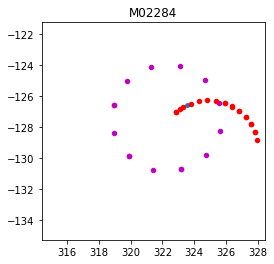

In [16]:
pos = 'M02284'
fit_arcs(pos, moves, cals, new_cals, 0, diag=True, tol=30)
plot_fiber(pos)

In [72]:
new_cals[:20].show_in_notebook()

idx,pos_id,length_r1,length_r2,offset_x,offset_y,arc_t,arc_p,rms_t,rms_p,err.length_r2,err.offset_xy,nfit_t,nfit_p,nprune_t,nprune_p,theta_arc_radius,theta_arc_phi,median_angstep_t,median_angstep_p,rms_angstep_t,rms_angstep_p,max_p
0,M00282,3.0987,3.0716,226.0922,23.2951,330.0400,120.2603,0.0028,0.0034,0.0029,0.0011,15,21,0,0,2.7845,126.3503,30.0337,9.9703,0.0983,0.2298,179.1953
1,M00283,2.9716,3.0405,80.1676,41.3665,329.8689,120.4988,0.0031,0.0023,0.0019,0.0013,15,21,0,0,2.5336,130.1669,29.9830,10.0655,0.1682,0.0841,180.0347
2,M00284,3.0378,3.0676,252.1764,32.3116,329.8996,119.9438,0.0024,0.0035,0.0031,0.0010,15,21,0,0,2.4826,132.0181,30.0136,9.9622,0.1363,0.0753,179.8803
3,M00296,3.0940,3.0839,194.8388,23.2824,329.9142,120.1023,0.0036,0.0033,0.0028,0.0015,15,21,0,0,2.7928,126.2493,29.9811,10.0019,0.1047,0.2614,178.7255
4,M00325,3.1777,3.0534,121.8863,23.3050,329.9311,119.7855,0.0031,0.0022,0.0019,0.0013,15,21,0,0,2.7075,128.5384,29.9848,10.0540,0.1302,0.2746,180.2602
5,M00411,3.1561,3.0468,347.1885,194.9642,329.9325,120.2110,0.0046,0.0031,0.0027,0.0019,15,21,0,0,2.7953,126.4650,29.9925,10.0189,0.1350,0.1534,179.3195
6,M00436,2.7827,3.1326,189.5691,50.4924,329.6800,69.5633,0.0021,0.0027,0.0074,0.0009,15,21,0,0,1.3933,153.5959,29.8845,5.6621,0.2914,0.8933,169.0661
7,M00469,3.0522,3.1255,179.1296,50.4416,330.0166,101.9804,0.0024,0.0024,0.0029,0.0010,15,21,0,0,1.8614,144.9525,30.0278,9.8289,0.1920,1.3889,179.5627
8,M00470,3.0171,3.0607,352.4130,185.9003,330.1303,119.5413,0.0038,0.0031,0.0027,0.0015,15,21,0,0,2.6235,128.8615,30.0539,9.9676,0.1344,0.0899,179.6039
9,M00636,2.9855,3.0471,299.1427,41.3353,330.1295,119.9699,0.0026,0.0029,0.0025,0.0011,15,21,0,0,2.5493,130.0176,30.0216,9.9858,0.0821,0.0981,179.7273


In [73]:
arc = new_cals['arc_t']
print(len(arc))

5020


In [74]:
tried = (cals['device_classified_nonfunctional']==False)
print(f"{np.sum(tried):4d} were tried")
print(f"{np.sum(tried&(arc<-7.5)):4d} didn't move")
print(f"{np.sum(tried&(arc<-4.5)&(arc>-7.5)):4d} rejected too many points")
print(f"{np.sum(tried&(arc<-0.5)&(arc>-4.5)):4d} failed to fit an arc")
print(f"{np.sum(tried&(arc>-0.5)&(arc<60)):4d} have too short an arc")

4848 were tried
   9 didn't move
   1 rejected too many points
   0 failed to fit an arc
   1 have too short an arc


In [75]:
new_cals[tried&(arc<-7.5)]

pos_id,length_r1,length_r2,offset_x,offset_y,arc_t,arc_p,rms_t,rms_p,err.length_r2,err.offset_xy,nfit_t,nfit_p,nprune_t,nprune_p,theta_arc_radius,theta_arc_phi,median_angstep_t,median_angstep_p,rms_angstep_t,rms_angstep_p,max_p
str6,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32
M01282,0.0000,3.0730,0.0000,0.0000,-8.0000,72.4853,0.0000,0.0026,0.0065,0.0000,15,21,0,0,0.0000,0.0000,0.0000,5.7747,0.0000,0.7987,76.3387
M03409,0.0000,0.0000,0.0000,0.0000,-9.0000,-9.0000,0.0000,0.0000,0.0000,0.0000,0,0,0,0,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000
M03545,0.0000,3.0775,0.0000,0.0000,-8.0000,74.4100,0.0000,0.0029,0.0068,0.0000,15,21,0,0,0.0000,0.0000,0.0000,5.9119,0.0000,0.9020,107.0356
M04083,0.0000,3.0527,0.0000,0.0000,-8.0000,60.0991,0.0000,0.0021,0.0089,0.0000,15,15,0,0,0.0000,0.0000,0.0000,9.9648,0.0000,0.1729,277.7862
M04235,0.0000,0.0000,0.0000,0.0000,-8.0000,-8.0000,0.0000,0.0000,9.9900,0.0000,15,21,0,0,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000
M05066,0.0000,0.0000,0.0000,0.0000,-9.0000,-9.0000,0.0000,0.0000,0.0000,0.0000,0,0,0,0,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000
M05445,0.0000,3.0456,0.0000,0.0000,-8.0000,99.2780,0.0000,0.0024,0.0033,0.0000,15,19,0,0,0.0000,0.0000,0.0000,10.0581,0.0000,0.4464,273.8779
M05515,0.0000,3.0783,0.0000,0.0000,-8.0000,79.8154,0.0000,0.0029,0.0070,0.0000,15,17,0,0,0.0000,0.0000,0.0000,9.9917,0.0000,0.0697,300.8798
M07863,0.0000,0.0000,0.0000,0.0000,-9.0000,-9.0000,0.0000,0.0000,0.0000,0.0000,0,0,0,0,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000


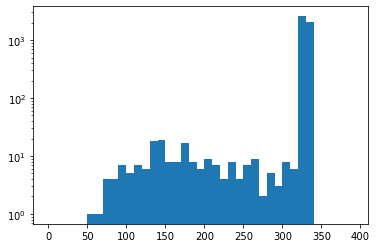

In [76]:
plt.hist(arc[tried&(arc>0)],range=[0,390],bins=39)
plt.semilogy()
plt.show()

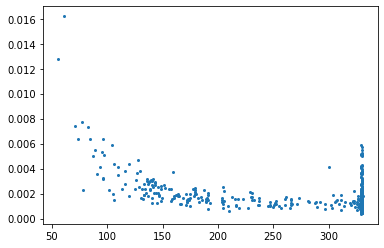

0.0011887479


In [77]:
sel = (arc>50)
plt.scatter(arc[sel], new_cals['err.offset_xy'][sel], s=4)
plt.show()
print(np.median(new_cals['err.offset_xy'][sel]))

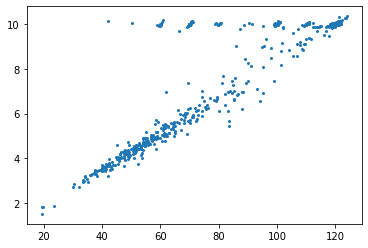

In [78]:
sel = (new_cals['arc_p']>0)
plt.scatter(new_cals['arc_p'][sel], new_cals['median_angstep_p'][sel],s=4)
plt.show()